In [1]:
%matplotlib inline
import datetime
import math
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from kam import KalmanAggModel

In [2]:
daily_std = .1 / math.sqrt(252.)
rand_step = lambda x: x * (1 + np.random.randn() * daily_std)

def rand_walk_pxs():
    x = 100
    while True:
        x = rand_step(x)
        yield x
        
def plot_model_performance(kf_ests, obs, target):
    res = pd.DataFrame(kf_ests, index=target.index, columns=['est_mean', 'var'])
    res['std'] = res['var'].map(math.sqrt)

    fig, ax = plt.subplots(nrows=3, figsize=[16,12])
    (pd.concat([res['est_mean'], obs,], axis=1)
     .plot(ax=ax[0], alpha=.7, title='obs vs est mean'))

    df = pd.DataFrame({'actual': target, 
                       'low_est': res['est_mean'] - res['std'], 
                       'high_est': res['est_mean'] + res['std']})
    df.plot(ax=ax[1], alpha=.7, title='actual vs est band')

    preds = pd.concat((res['est_mean'], obs.mean(axis=1)), axis=1)
    preds.columns = ['kf', 'avg']
    (pd.concat([target, preds], axis=1)
     .plot(ax=ax[2], alpha=.7, title='comparison with simple avg of preds'))  
    
    errs = preds.apply(lambda col: col - target, axis=0)
    print(errs.apply(abs).describe().loc[['mean', 'std'],:])
    corr = errs.corr().iloc[0,1]
    print('kf err corr w model avg err corr: {0:.3f}'.format(corr))

## random walk target time series

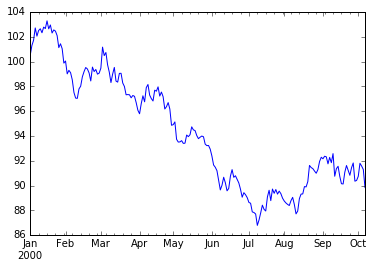

In [3]:
n = 200
px = rand_walk_pxs()
dr = pd.date_range(start=datetime.date(2000,1,1), periods=n, freq='B')
x = pd.Series([px.next() for i in range(n)], index=dr, name='actual')
x.plot()

## uncorrelated model predictions

In [4]:
obs = pd.concat([x + np.random.randn(*x.shape) * 5,
                 x + np.random.randn(*x.shape) * 5,
                 x + np.random.randn(*x.shape) * 10,], axis=1)
obs.columns = map(lambda x: 'ob_{0}'.format(x), range(obs.shape[1]))
obs.corrwith(x)

ob_0    0.655191
ob_1    0.653474
ob_2    0.293224
dtype: float64

In [5]:
errs = obs.apply(lambda col: col - x, axis=0)
errs.corr()

,ob_0,ob_1,ob_2
ob_0,1.000000,-0.119873,0.022871
ob_1,-0.119873,1.000000,0.072876
ob_2,0.022871,0.072876,1.000000


In [6]:
seed_split = 100

            kf       avg
mean  1.424608  2.967102
std   1.035925  2.394783
kf err corr w model avg err corr: 0.480


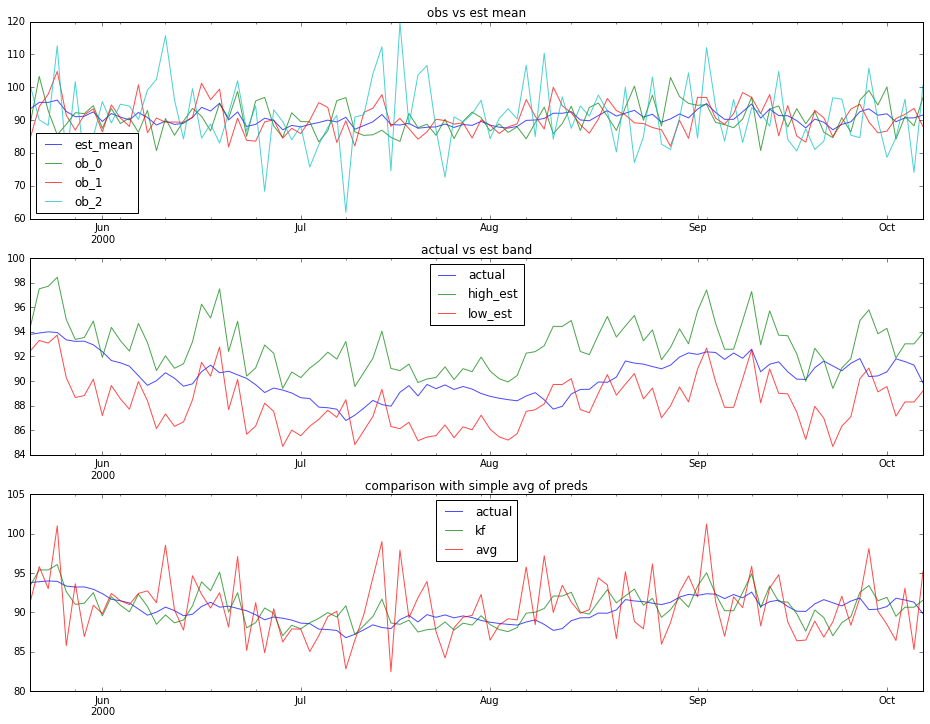

In [7]:
x_seed, obs_seed = map(lambda x: x.iloc[:seed_split], (x, obs))
x_tst, obs_tst = map(lambda x: x.iloc[seed_split:], (x, obs))

ag = KalmanAggModel(obs_seed.values, x_seed.values, x_seed[-1])
res = ag.fit(obs_tst.values)
plot_model_performance(res, obs_tst, x_tst)

## uncorrelated model predictions w low error variance

In [8]:
obs = pd.concat([x + np.random.randn(*x.shape),
                 x + np.random.randn(*x.shape),
                 x + np.random.randn(*x.shape),], axis=1)
obs.columns = map(lambda x: 'ob_{0}'.format(x), range(obs.shape[1]))
obs.corrwith(x)

ob_0    0.979850
ob_1    0.978540
ob_2    0.979366
dtype: float64

In [9]:
errs = obs.apply(lambda col: col - x, axis=0)
errs.corr()

,ob_0,ob_1,ob_2
ob_0,1.000000,-0.039978,-0.133993
ob_1,-0.039978,1.000000,-0.015372
ob_2,-0.133993,-0.015372,1.000000


            kf      avg
mean  0.388250  0.40426
std   0.275048  0.29845
kf err corr w model avg err corr: 0.987


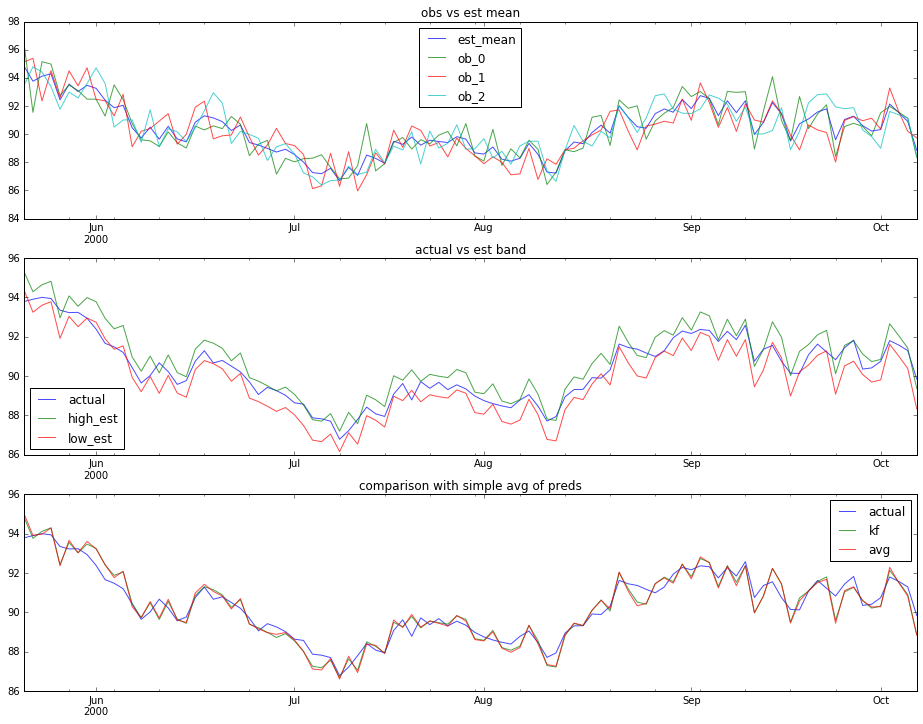

In [10]:
x_seed, obs_seed = map(lambda x: x.iloc[:seed_split], (x, obs))
x_tst, obs_tst = map(lambda x: x.iloc[seed_split:], (x, obs))

ag = KalmanAggModel(obs_seed.values, x_seed.values, x_seed[-1])
res = ag.fit(obs_tst.values)
plot_model_performance(res, obs_tst, x_tst)

## correlated model predictions

In [11]:
corr = np.array([[1, .25, .9],
                 [.25, 1, .5],
                 [.9, .5, 1.],])

std = np.array([5, 5, 10])
dstd = np.diag(std)
cov = dstd.dot(corr).dot(dstd)

errs = np.random.multivariate_normal(np.array([0,0,0]), cov, x.shape)
obs = pd.DataFrame(errs, index=x.index).add(x, axis=0)
obs.columns = map(lambda x: 'ob_{0}'.format(x), range(obs.shape[1]))
obs.corrwith(x)

ob_0    0.716228
ob_1    0.708282
ob_2    0.522652
dtype: float64

In [12]:
errs = obs.apply(lambda col: col - x, axis=0)
errs.corr()

,ob_0,ob_1,ob_2
ob_0,1.000000,0.178305,0.889582
ob_1,0.178305,1.000000,0.475769
ob_2,0.889582,0.475769,1.000000


            kf       avg
mean  1.055309  4.545355
std   0.974825  3.214760
kf err corr w model avg err corr: 0.223


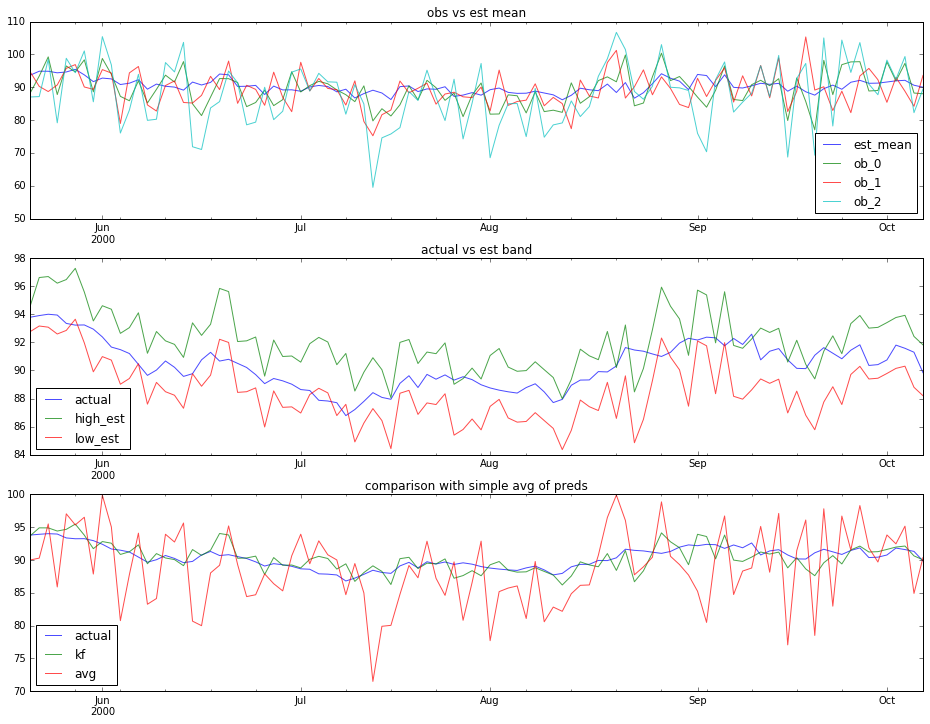

In [13]:
x_seed, obs_seed = map(lambda x: x.iloc[:seed_split], (x, obs))
x_tst, obs_tst = map(lambda x: x.iloc[seed_split:], (x, obs))

ag = KalmanAggModel(obs_seed.values, x_seed.values, x_seed[-1])
res = ag.fit(obs_tst.values)
plot_model_performance(res, obs_tst, x_tst)